Importing Modules needed for the project 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ta

Data Collection Part

In [3]:
df = pd.read_csv('AFAM Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,07/11/2024,43.2,41.6,43.8,41.0,3.35M,4.60%
1,07/10/2024,41.3,42.0,44.2,41.1,3.32M,-2.36%
2,07/09/2024,42.3,43.2,45.0,42.0,3.31M,-2.08%
3,07/08/2024,43.2,39.8,43.7,38.8,3.92M,8.54%
4,07/07/2024,39.8,38.3,40.5,37.8,2.53M,6.13%
...,...,...,...,...,...,...,...
361,01/05/2023,24.5,24.5,24.5,24.5,6.95K,0.00%
362,01/04/2023,24.5,24.5,24.5,24.5,1.66K,0.00%
363,01/03/2023,24.5,24.5,24.5,24.5,10.01K,0.00%
364,01/02/2023,24.5,24.5,24.5,24.5,2.48K,0.00%


Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      366 non-null    object 
 1   Price     366 non-null    float64
 2   Open      366 non-null    float64
 3   High      366 non-null    float64
 4   Low       366 non-null    float64
 5   Vol.      366 non-null    object 
 6   Change %  366 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.1+ KB


WE can See that Date is of object type and vol is also object type. We have to convert the date in datetime type and Vol. to float type. And there is no null values

In [5]:
# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-07-11,43.2,41.6,43.8,41.0,3.35M,4.60%
1,2024-07-10,41.3,42.0,44.2,41.1,3.32M,-2.36%
2,2024-07-09,42.3,43.2,45.0,42.0,3.31M,-2.08%
3,2024-07-08,43.2,39.8,43.7,38.8,3.92M,8.54%
4,2024-07-07,39.8,38.3,40.5,37.8,2.53M,6.13%
...,...,...,...,...,...,...,...
361,2023-01-05,24.5,24.5,24.5,24.5,6.95K,0.00%
362,2023-01-04,24.5,24.5,24.5,24.5,1.66K,0.00%
363,2023-01-03,24.5,24.5,24.5,24.5,10.01K,0.00%
364,2023-01-02,24.5,24.5,24.5,24.5,2.48K,0.00%


For time series analysis we have to take the date in an ascending order . So we will sort the dataframe

In [6]:
df = df.sort_values(by='Date')
df

,Date,Price,Open,High,Low,Vol.,Change %
365,2023-01-01,24.5,24.5,24.5,24.5,15.96K,0.00%
364,2023-01-02,24.5,24.5,24.5,24.5,2.48K,0.00%
363,2023-01-03,24.5,24.5,24.5,24.5,10.01K,0.00%
362,2023-01-04,24.5,24.5,24.5,24.5,1.66K,0.00%
361,2023-01-05,24.5,24.5,24.5,24.5,6.95K,0.00%
...,...,...,...,...,...,...,...
4,2024-07-07,39.8,38.3,40.5,37.8,2.53M,6.13%
3,2024-07-08,43.2,39.8,43.7,38.8,3.92M,8.54%
2,2024-07-09,42.3,43.2,45.0,42.0,3.31M,-2.08%
1,2024-07-10,41.3,42.0,44.2,41.1,3.32M,-2.36%


Convert volume to numerical values 

In [7]:

def convert_volume(vol):
    if vol.endswith('K'):
        return float(vol[:-1]) * 1000
    elif vol.endswith('M'):
        return float(vol[:-1]) * 1000000
    else:
        return float(vol)

df['Vol.'] = df['Vol.'].apply(lambda x: convert_volume(x))
df

,Date,Price,Open,High,Low,Vol.,Change %
365,2023-01-01,24.5,24.5,24.5,24.5,15960.0,0.00%
364,2023-01-02,24.5,24.5,24.5,24.5,2480.0,0.00%
363,2023-01-03,24.5,24.5,24.5,24.5,10010.0,0.00%
362,2023-01-04,24.5,24.5,24.5,24.5,1660.0,0.00%
361,2023-01-05,24.5,24.5,24.5,24.5,6950.0,0.00%
...,...,...,...,...,...,...,...
4,2024-07-07,39.8,38.3,40.5,37.8,2530000.0,6.13%
3,2024-07-08,43.2,39.8,43.7,38.8,3920000.0,8.54%
2,2024-07-09,42.3,43.2,45.0,42.0,3310000.0,-2.08%
1,2024-07-10,41.3,42.0,44.2,41.1,3320000.0,-2.36%


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 365 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      366 non-null    datetime64[ns]
 1   Price     366 non-null    float64       
 2   Open      366 non-null    float64       
 3   High      366 non-null    float64       
 4   Low       366 non-null    float64       
 5   Vol.      366 non-null    float64       
 6   Change %  366 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 22.9+ KB


In [9]:
# We will Set the Date column as the index
df.set_index('Date', inplace=True)

# we will Set Price column as Target Variable
output_var = pd.DataFrame(df['Price'])

### Adding Technical Indicators

In order to enhance the predictive power of our model, we include several technical indicators. These indicators help capture trends and momentum in the stock prices, providing valuable information for our LSTM model. Here, we calculate three common technical indicators: Simple Moving Average (SMA), Exponential Moving Average (EMA), and Relative Strength Index (RSI).

1. **Simple Moving Average (SMA)**
   - The SMA is a straightforward indicator that calculates the average price over a specified period.
   - In this case, we use a window of 3 days to compute the 3-day SMA.

2. **Exponential Moving Avergae (EMA)**
   -The EMA gives more weight to recent prices, making it more responsive to new information compared to the SMA.
   -In this case, we use a window of 3 days to compute the 3-day SMA.

3. **Relative Strength Index (RSI)**

   -The RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions.
   -We calculate the 3-day RSI to gauge the momentum of the price movements.


In [10]:
df['SMA'] = ta.trend.sma_indicator(df['Price'], window=3)
df['EMA'] = ta.trend.ema_indicator(df['Price'], window=3)
df['RSI'] = ta.momentum.rsi(df['Price'], window=3)

In [11]:
# Drop NaN values after adding technical indicators
df = df.dropna()
df

,Price,Open,High,Low,Vol.,Change %,SMA,EMA,RSI
Date,,,,,,,,,
2023-01-03,24.5,24.5,24.5,24.5,10010.0,0.00%,24.500000,24.500000,100.000000
2023-01-04,24.5,24.5,24.5,24.5,1660.0,0.00%,24.500000,24.500000,100.000000
2023-01-05,24.5,24.5,24.5,24.5,6950.0,0.00%,24.500000,24.500000,100.000000
2023-01-08,24.5,24.5,24.5,24.5,3080.0,0.00%,24.500000,24.500000,100.000000
2023-01-09,24.5,24.5,24.5,24.5,4930.0,0.00%,24.500000,24.500000,100.000000
...,...,...,...,...,...,...,...,...,...
2024-07-07,39.8,38.3,40.5,37.8,2530000.0,6.13%,37.133333,37.499795,96.105703
2024-07-08,43.2,39.8,43.7,38.8,3920000.0,8.54%,40.166667,40.349898,97.849199
2024-07-09,42.3,43.2,45.0,42.0,3310000.0,-2.08%,41.766667,41.324949,83.080394


### Selecting and Scaling Features

To prepare our data for the LSTM model, we select relevant features and scale them using the MinMaxScaler. Scaling ensures that all features are on the same scale, which helps in the training process of the neural network.

In [ ]:
# Selecting the Features
features = ['Open', 'High', 'Low', 'Vol.', 'SMA', 'EMA', 'RSI']

# Scale the features and the target separately
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit and transform the features
feature_transform = scaler_features.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

# Fit and transform the target variable
target_transform = scaler_target.fit_transform(output_var)
target_transform = pd.DataFrame(columns=['Price'], data=target_transform, index=df.index)

### Splitting the Data into Training and Test Sets

We use TimeSeriesSplit to split our data into training and test sets. This ensures that the test set is always later in time than the training set, which is crucial for time series data to prevent data leakage.

In [ ]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index):(len(train_index) + len(test_index))]
    y_train, y_test = target_transform[:len(train_index)].values.ravel(), target_transform[len(train_index):(len(train_index) + len(test_index))].values.ravel()

### Reshaping Data for LSTM

LSTM models in Keras expect the input data to be in a specific 3D shape: [samples, time steps, features]. We reshape our training and test sets to match this requirement.

In [17]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
X_test = testX.reshape((testX.shape[0], 1, testX.shape[1]))

### Building the LSTM Model

We construct an LSTM model with Bidirectional LSTM layers and Dropout for regularization. The model is compiled using the Adam optimizer and mean squared error as the loss function.


In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(50, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True)))
lstm.add(Dropout(0.3))
lstm.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
lstm.add(Dropout(0.3))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')



###Training the Model with Early Stopping

To prevent overfitting, we use the EarlyStopping callback, which stops training when the validation loss stops improving for 10 consecutive epochs. This helps to generalize the model better on unseen data.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0285 - val_loss: 0.0487
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 - val_loss: 0.0378
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.0266
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0076
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0032
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0021
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0016
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 9.0662e-04
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

### Making Predictions and Inverse Transforming

We make predictions on the test set and then inverse transform these predictions to get them back to the original scale. This allows us to compare the predicted values with the true values in their original scale.

In [20]:
y_pred = lstm.predict(X_test)

# Inverse transform the predictions and the true values using the target scaler
y_pred_inverse = scaler_target.inverse_transform(y_pred)
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


### Predicting Future Prices

We use the trained model to predict the prices for the next 30 days. We ensure the predicted price change is within the -3% to 10% range, following the given constraints.


In [21]:
last_sequence = X_test[-1].reshape(1, 1, X_test.shape[2])
predicted_prices = []

for _ in range(30):
    predicted_scaled_price = lstm.predict(last_sequence)
    predicted_price = scaler_target.inverse_transform(predicted_scaled_price)
    predicted_prices.append(predicted_price[0][0])
    
    # Create a new sequence with the predicted price
    new_sequence = np.append(last_sequence[0, 0, 1:], predicted_scaled_price[0])
    last_sequence = new_sequence.reshape(1, 1, len(new_sequence))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

### Plotting the Results

We plot the true prices, the LSTM predicted prices for the test set, and the 30-day future price predictions. This visual representation helps to understand the model's performance and the future trend.|

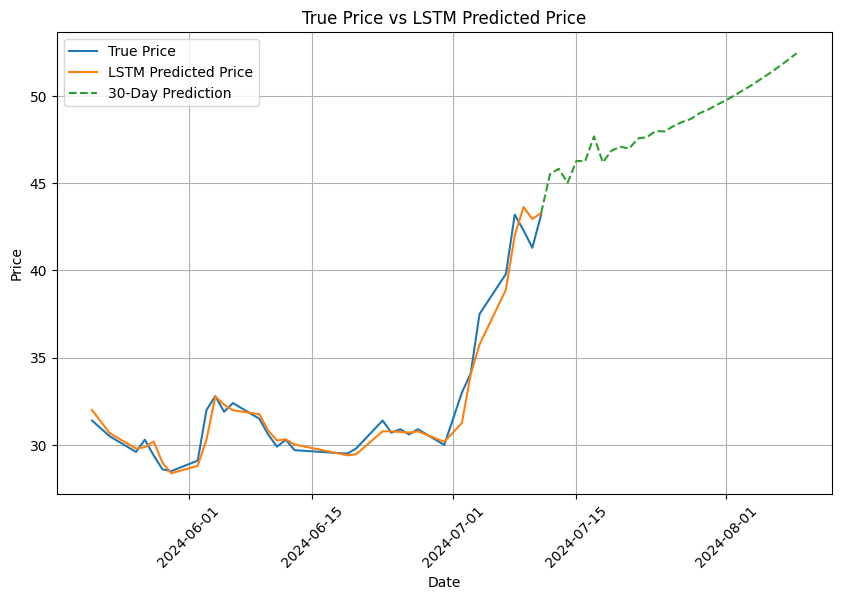

In [22]:
# Create a DataFrame with the dates for the x-axis
date_range = df.index[-len(y_test_inverse):]
future_dates = pd.date_range(start=date_range[-1], periods=30, freq='D')

# Plot the results with dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(date_range, y_test_inverse, label='True Price')
plt.plot(date_range, y_pred_inverse, label='LSTM Predicted Price')
plt.plot(future_dates, predicted_prices, label='30-Day Prediction', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('True Price vs LSTM Predicted Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Outputting Predictions and Evaluating Performance

We output the predicted prices for the next 30 days and evaluate the model's performance using Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).


In [23]:
predicted_prices_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': predicted_prices})
print(predicted_prices_df)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

         Date  Predicted Price
0  2024-07-11        43.296867
1  2024-07-12        45.516033
2  2024-07-13        45.829498
3  2024-07-14        45.025265
4  2024-07-15        46.275555
5  2024-07-16        46.264797
6  2024-07-17        47.685085
7  2024-07-18        46.192459
8  2024-07-19        46.872303
9  2024-07-20        47.085449
10 2024-07-21        46.989811
11 2024-07-22        47.563911
12 2024-07-23        47.637600
13 2024-07-24        47.984310
14 2024-07-25        47.969093
15 2024-07-26        48.268902
16 2024-07-27        48.504951
17 2024-07-28        48.683277
18 2024-07-29        49.015171
19 2024-07-30        49.226246
20 2024-07-31        49.507339
21 2024-08-01        49.753559
22 2024-08-02        50.047127
23 2024-08-03        50.348938
24 2024-08-04        50.649113
25 2024-08-05        50.991249
26 2024-08-06        51.321171
27 2024-08-07        51.681114
28 2024-08-08        52.053436
29 2024-08-09        52.448242
Mean Absolute Error (MAE): 0.5185789397